In [1]:
import logging
import time
from tqdm import tqdm

import torch
from torchvision import transforms, datasets

import numpy as np

from CnnGAN import Discriminator, Generator, show_plt, createOnehot2DSeed

In [2]:
logging.basicConfig(filename='log/train.log', level=logging.INFO)

In [3]:
device = 'cpu'
# mps에서는 conv_transpose2d 구현되지 않음
# if torch.mps.is_available():
#     device = 'mps'

if torch.cuda.is_available():
    device = 'cuda'

print(device)

cuda


In [4]:
train_dataset = datasets.MNIST(root = "../data/",
                               train = True,
                               transform = transforms.ToTensor())
num_classes = len(train_dataset.classes)

In [5]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion = torch.nn.BCELoss()
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
genr_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)

In [6]:
def train_step(model, x, target, criterion, optimizer):
    model.train()
    pred = model(x)
    pred = pred.squeeze(dim=0)
    loss = criterion(pred, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

### 주의사항
 - 모델에 시드 값이 정규분포를 따를때 생성기의 학습이 잘됨 -> 그냥 랜덤값이면 학습 안됨
 - 모델 만들때, Normalizer, Activation 함수가 어떤것이냐에 따라 차이를 많이 보임
   - 현재 코드에서는 LayerNormalizer, LeakliyRelu 가 가장 빠르게 모드 붕괴를 해소함

  0%|                                             | 0/4 [00:06<?, ?it/s, 939/60000, dis_loss: 0.1875, gen_loss: 2.6336]


KeyboardInterrupt: 

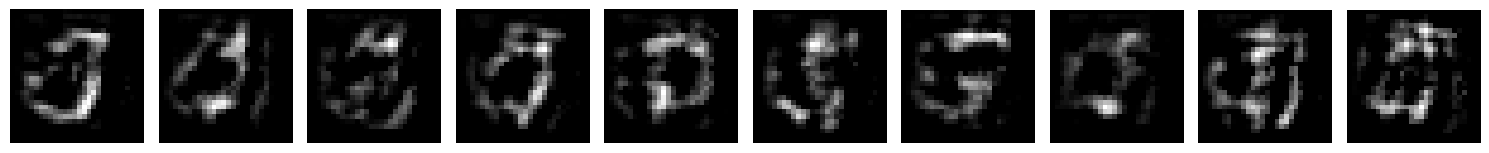

In [8]:
bestest = float('inf')

progress = tqdm(range(4))
for epoch in progress:
    dis_losses = []
    gen_losses = []

    start_time = time.time()
    elapsed = int(time.time() - start_time)
    
    for step, (x, label) in enumerate(train_dataset):
        x = x.reshape(1, *x.shape).to(device)
        target = torch.Tensor([1.]).to(device)
        pos_loss = train_step(discriminator, x, target, criterion, disc_optimizer)

        seed = createOnehot2DSeed([label], num_classes)
        seed = seed.to(device)
        x = generator(seed).detach()
        target = torch.Tensor([0.]).to(device)
        neg_loss = train_step(discriminator, x, target, criterion, disc_optimizer)

        seed = createOnehot2DSeed([label], num_classes)
        seed = seed.to(device)
        x = generator(seed)
        target = torch.Tensor([1.]).to(device)
        gen_loss = train_step(discriminator, x, target, criterion, genr_optimizer)

        dis_losses.append(pos_loss)
        dis_losses.append(neg_loss)
        gen_losses.append(gen_loss)

        progress.set_postfix_str(f"{step + 1}/{len(train_dataset)}, dis_loss: {np.mean(dis_losses):.04f}, gen_loss: {np.mean(gen_losses):.04f}")
        if step % 10000 == 0:
            show_plt(generator, num_classes, f'log/checkpoint_{epoch}_{step}.png')
            logging.info(f'Epoch {epoch}, Step {step}, elapsed: {elapsed}, DiscLoss: {np.mean(dis_losses):.04f}, GenLoss: {np.mean(gen_losses):.04f}')

    if bestest > np.mean(gen_losses):
        checkpoint = {
            'epoch': epoch,
            'gen_model_state_dict': generator.state_dict(),
            'disc_model_state_dict': discriminator.state_dict(),
            'gen_optimizer_state_dict': genr_optimizer.state_dict(),
            'disc_optimizer_state_dict': disc_optimizer.state_dict(),
            'disc_loss': np.mean(dis_losses),
            'gen_loss': np.mean(gen_losses),
        }
        torch.save(checkpoint, f'log/checkpoint_{epoch}.pth')
        bestest = loss_gap

    checkpoint = {
        'epoch': epoch,
        'gen_model_state_dict': generator.state_dict(),
        'disc_model_state_dict': discriminator.state_dict(),
        'gen_optimizer_state_dict': genr_optimizer.state_dict(),
        'disc_optimizer_state_dict': disc_optimizer.state_dict(),
        'disc_loss': np.mean(dis_losses),
        'gen_loss': np.mean(gen_losses),
    }
    torch.save(checkpoint, f'log/latest.pth')

generator.eval()
show_plt(generator, 10)

In [ ]:
generator.eval()
show_plt(generator, 10)